# PatchTST Model Development

In this section we will develop the PatchTST model to predict S&P Close, Dow Jones Close.

## Model Congfiguration 

We will configure the PatchTST model based on the `Economic_Data_1994_2025` dataset we processed

In [15]:
from transformers import PatchTSTConfig, PatchTSTForPrediction, PatchTSTForPretraining
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import torch

ImportError: cannot import name 'PatchTST' from 'transformers' (/opt/anaconda3/envs/Personal_Proj/lib/python3.12/site-packages/transformers/__init__.py)

In [3]:
dataset = pd.read_csv('../data/Economic_Data_1994-2025.csv')
dataset = dataset.drop(['DATE', 'Unnamed: 0'], axis=1)

col_id = {}
curr_id = 0
for col in dataset:
    col_id[col] = curr_id
    curr_id = curr_id + 1

# Dictionary of what each index represents
col_id

{'^GSPC Close': 0,
 '^GSPC High': 1,
 '^GSPC Low': 2,
 '^GSPC Open': 3,
 '^GSPC Volume': 4,
 '^DJI Close': 5,
 '^DJI High': 6,
 '^DJI Low': 7,
 '^DJI Open': 8,
 '^DJI Volume': 9,
 '^IXIC Close': 10,
 '^IXIC High': 11,
 '^IXIC Low': 12,
 '^IXIC Open': 13,
 '^IXIC Volume': 14,
 'CPIAUCSL': 15,
 'DFF': 16,
 'UNRATE': 17,
 'GDP': 18,
 'WM2NS': 19,
 'ICSA': 20,
 'JTS2300JOL': 21,
 'JTS1000JOL': 22,
 'JTSJOL': 23,
 'PCE': 24,
 'REVOLSL': 25,
 'TDSP': 26,
 'CDSP': 27,
 'T10Y2Y': 28,
 'T10YFF': 29,
 'INDPRO': 30,
 'TCU': 31,
 'RSAFS': 32,
 'PSAVERT': 33,
 'MORTGAGE30US': 34,
 'HOUST': 35,
 'PI': 36}

### Understanding PatchTST

- **Context Length**

    Context length is how far we look back in total. If we were trying to predict the closing price for the SP500 tomorrow, our context length would be how far we look back to make our prediction.

- **Patch Length**

    Patch length is like a subset of our context length. When looking at our entire context length, patch length is the looking at each individual week up until tomorrow to make our final prediction

- **Patch Stride**

    Patch stride is how far our patch length will move after observing an individual week. We can overlap weeks to see any comparisons. 

In [4]:
# How many features we are including 
NUM_INPUT = len(dataset.columns)

# For What we are predicting
NUM_TARGET = 2

# How many steps we take in the context length
CONTEXT_LEN = 365

# How many steps we take in the context length
PATCH_LEN = 10

# How far we move our patch length
PATCH_STRD = 5

NUM_ATT_HEADS = 8

# How many days to predict into the future
PRED_LEN = int(365 / 4)

# Configuring Model
config = PatchTSTConfig(
    num_input_channels = NUM_INPUT,
    num_target = NUM_TARGET,
    context_length = CONTEXT_LEN,
    patch_length = PATCH_LEN,
    patch_stride = PATCH_STRD,
    num_attention_heads = NUM_ATT_HEADS,
    prediction_length = PRED_LEN
)

model = PatchTSTForPrediction(config)
model

PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=10, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128, eps

In [5]:
# Set up constraints for development
num_train = int(len(dataset) * .7)
num_test = int(len(dataset) * .2)
num_val = int(len(dataset) * .1)

targets = dataset
features = dataset

**Getting Target/Input Features**

This part is a little odd. 

- **Input Features**

    To get the target features all we need to do is construct a window that looks at the past N amount of days for each data point.
    We include the features we want to predict which makes it **Self Supervised**. 

- **Output Features**

    What we are doing is getting the actual targets we want to predict and making a future window for just the 2 features. 
    In this case we are looking 90 days into the future, or what the model is predicting, and grabbing those values. This is used 
    for the model to evalute it's prediction

In [6]:
# Creates a context window for each data point to feed into the model during training
def create_sequence_windows(data, window_size):
    windows = []
    
    # We start in the dataFrame at an index 'window_size' and look back depending on the window size
    # We will grab a context window for all data points
    for i in range(len(data) - window_size + 1):
        windows.append(data.iloc[i:i+window_size].values)
    return np.array(windows)

input_windows = create_sequence_windows(features, CONTEXT_LEN)

# Remove values at the end that don't have enough future data
input_windows = input_windows[0:7459-91]

In [7]:
# Gets indices for the target variables, starting from where we first start predicting with a full context length
# to the last index that will allow for a full prediction
target_indices = range(CONTEXT_LEN, len(features) - PRED_LEN + 1)

In [8]:
target_windows = [targets.iloc[i:i+PRED_LEN].values for i in target_indices]
target_windows = np.array(target_windows)
target_windows.shape

(7368, 91, 37)

In [9]:
past_values = torch.tensor(input_windows, dtype=torch.float32)
future_values = torch.tensor(target_windows, dtype=torch.float32)

In [10]:
data = TensorDataset(past_values, future_values)
dataloader = DataLoader(data, batch_size=32, shuffle=True)

In [11]:
device = torch.device('mps')
model = model.to(device)

In [12]:
from tqdm import tqdm

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
epochs = 10

model.train()
for epoch in range(epochs):

    loop = tqdm(dataloader, leave=True)
    losses = []
    
    for past_values, future_values in loop:
        optimizer.zero_grad()
        
        past_values = past_values.to(device)
        future_values = future_values.to(device)
        
        outputs = model(past_values=past_values, future_values=future_values)
        
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch 9: 100%|██████████| 231/231 [01:27<00:00,  2.65it/s, loss=10.5]


In [14]:
torch.save(model.state_dict(), 'Economic_Model_V1.bin')

## Evaluate

In [22]:
model_eval = PatchTSTForPrediction(config=config)

model_eval.load_state_dict(torch.load('Economic_Model_V1.bin'))
model_eval.eval()


PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=10, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128, eps

In [23]:
features = dataset.iloc[-CONTEXT_LEN:].values  # Last CONTEXT_LEN days
x = torch.FloatTensor(features).unsqueeze(0)

In [30]:
with torch.no_grad():
    predictions = model_eval(x)

predictions = predictions.prediction_outputs

In [54]:
predictions = predictions.squeeze(0).numpy()

In [55]:
pred_np =predictions

(91, 37)

In [50]:
import pandas as pd
from datetime import datetime, timedelta

df = pd.read_csv('../data/Economic_Data_1994-2025.csv')

# Get the last date in your dataset
last_date = pd.to_datetime(df['DATE'])
last_date = last_date[7822]

# Create date range for predictions
future_dates = pd.date_range(
    start=last_date + timedelta(days=1),
    periods=PRED_LEN,
    freq='D'
)



Timestamp('2025-03-30 00:00:00')

In [66]:
df_copy = df.drop(['DATE', 'Unnamed: 0'], axis=1)

pred_df = pd.DataFrame(pred_np, columns=df_copy.columns)

pred_df['DATE'] = future_dates

result_df = pd.concat([df, pred_df], ignore_index=True)

In [82]:
result_df['DATE'] = pd.to_datetime(result_df['DATE'])

In [85]:
import matplotlib.pyplot as plt

def plot_time_frame_x2(year_start, year_end, df, x1, x2):
    df_tf = df[(df['DATE'].dt.year >= year_start) & (df['DATE'].dt.year <= year_end)]

    plt.plot(df_tf['DATE'], df_tf[x1], label=x1)
    plt.plot(df_tf['DATE'], df_tf[x2], label=x2)
    plt.legend()
    plt.show()

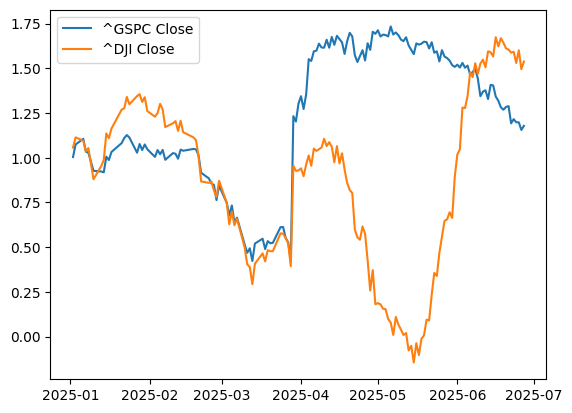

In [86]:
plot_time_frame_x2(2025, 2025, result_df, '^GSPC Close', '^DJI Close')